In [6]:
# import library and load dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# load dataset
data_path = '../../data/processed/data_cleaned_scaled_onehot.csv' 
data = pd.read_csv(data_path)

# form features and target
X = data.drop(['Target'], axis=1)
y = data['Target']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# hyperparameter search for random forest

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'criterion': 'gini', 'max_depth': 40, 'n_estimators': 100}
0.8770850338502905


In [8]:
# use cross validation to evaluate random forest model consistency on X_train data

rf = RandomForestClassifier(n_estimators=100, max_depth=40, criterion='gini', random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy')
print("accuracy mean:", scores.mean(), "accuracy std:", scores.std())

accuracy mean: 0.8770850338502905 accuracy std: 0.00885023335244019


In [9]:
# classfication with random forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=40, criterion='gini', random_state=42)

# train random forest
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

# evaluate accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

# confusion matrix
from sklearn.metrics import confusion_matrix

print("")
print("confusion matrix: [TP, FP], [FN, TN]")
print(confusion_matrix(y_test, y_pred))


Accuracy:  0.8531073446327684
Precision:  0.8445839874411303
Recall:  0.945518453427065
F1:  0.8922056384742952

confusion matrix: [TP, FP], [FN, TN]
[[217  99]
 [ 31 538]]


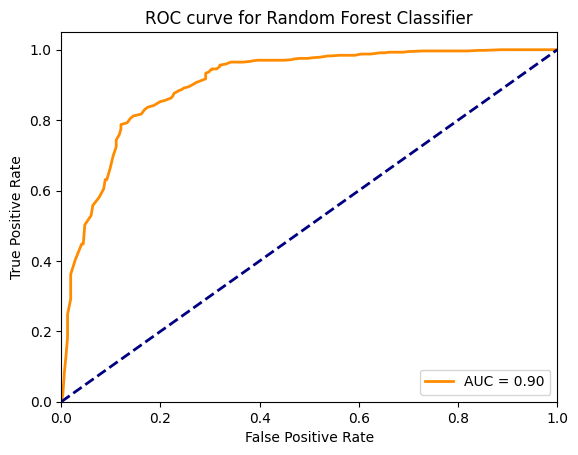

In [10]:
# build a ROC curve with different settings of decision tree
# then plot the ROC curve: false positive rate vs true positive rate

from sklearn.metrics import roc_curve, auc

y_pred_prob = rf.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()